#  DQN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

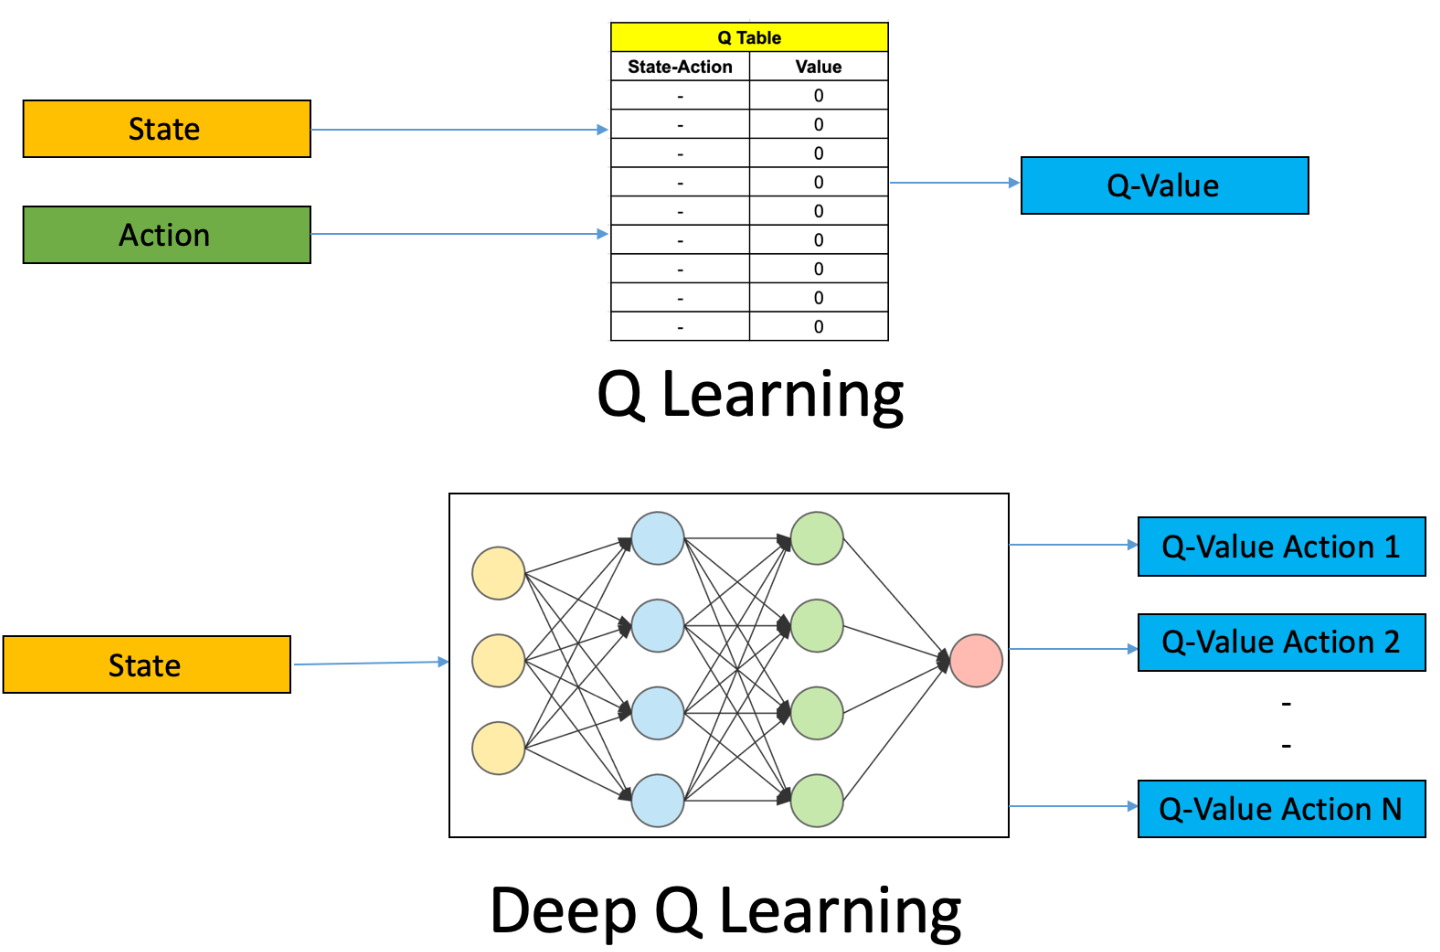

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.8 MB/s eta 0:00:00


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [ ] Проверено на семинаре

In [3]:
from collections import namedtuple, deque
import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory(object):
    def __init__(self, capacity):
        """capacity - максимальный размер хранилища"""
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)  # Используем deque для автоматического удаления старых записей

    def push(self, *args):
        """Сохраняет переход. При нехватке места в хранилище самые старые записи удаляются."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Возвращает batch_size случайно выбранных переходов"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Возвращает текущий размер памяти"""
        return len(self.memory)


<p class="task" id="2"></p>

2\. Допишите класс `DQN` для моделирования Q-функции.

- [ ] Проверено на семинаре

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """Нейронная сеть для моделирования Q-функции."""
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        # Определение архитектуры сети
        self.fc1 = nn.Linear(n_observations, 128)  # Первый полносвязный слой
        self.fc2 = nn.Linear(128, 64)             # Второй полносвязный слой
        self.fc3 = nn.Linear(64, n_actions)       # Выходной слой, предсказывающий Q-значения

    def forward(self, x):
        """Для каждого состояния должны получать n_actions чисел."""
        x = F.relu(self.fc1(x))  # Активация ReLU после первого слоя
        x = F.relu(self.fc2(x))  # Активация ReLU после второго слоя
        x = self.fc3(x)          # Выходной слой (без активации, т.к. предсказываем Q-значения)
        return x


<p class="task" id="3"></p>

3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики.

- [ ] Проверено на семинаре

In [5]:
from dataclasses import dataclass
import torch as th
import torch.nn as nn
import random

@dataclass
class PolicyConfig:
    """Содержит настройки для Policy: размерность пространства наблюдений, кол-во действий,
    устройство, на котором будет располагаться модели; ε и т.д."""
    n_observations: int
    n_actions: int
    device: th.device
    epsilon_start: float = 1.0
    epsilon_end: float = 0.1
    epsilon_decay: int = 1000

In [14]:
from dataclasses import dataclass
import torch as th
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gymnasium as gym
from gymnasium.wrappers import TransformObservation
import matplotlib.pyplot as plt

@dataclass
class TrainConfig:
    """Содержит настройки для процесса обучения: коэффициент дисконтирования, скорость обучения,
    количество эпизодов для обучения, размер батча и т.д."""
    gamma: float  # Коэффициент дисконтирования
    learning_rate: float  # Скорость обучения
    num_episodes: int  # Количество эпизодов
    batch_size: int  # Размер батча
    sync_target_steps: int  # Частота синхронизации policy и target
    memory_capacity: int  # Размер памяти
    epsilon_start: float  # Начальное значение epsilon
    epsilon_end: float  # Конечное значение epsilon
    epsilon_decay: int  # Количество шагов для уменьшения epsilon

class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        self.env = env
        self.config = train_config
        self.policy = policy

        # Критерий и оптимизатор
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy.policy_network.parameters(), lr=self.config.learning_rate)

        # Хранилище переходов
        self.memory = deque(maxlen=self.config.memory_capacity)

        # Метрики
        self.episode_rewards = []
        self.max_x_values = []

    def train(self):
        best_max_x = -float('inf')
        for episode in range(self.config.num_episodes):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)
            total_reward = 0
            max_x = -float('inf')

            done = False
            while not done:
                action = self.policy.get_best_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                max_x = max(max_x, next_state[0])
                next_state = th.tensor(next_state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)

                self.memory.append((state, action, next_state, reward, done))
                state = next_state
                total_reward += reward

                if len(self.memory) >= self.config.batch_size:
                    self.generate_batch_and_fit()

            self.episode_rewards.append(total_reward)
            self.max_x_values.append(max_x)

            # Синхронизация policy и target моделей
            if episode % self.config.sync_target_steps == 0:
                self.policy.sync_models()

            # Сохранение модели при улучшении
            if max_x > best_max_x:
                best_max_x = max_x
                self.policy.save("best_model")

            # Обновление epsilon
            self.policy.update_epsilon()

        # Визуализация метрик
        self.plot_metrics()

    def generate_batch_and_fit(self):
        transitions = random.sample(self.memory, self.config.batch_size)
        batch = list(zip(*transitions))

        states = th.cat(batch[0]).to(self.policy.cfg.device)
        actions = th.tensor(batch[1], dtype=th.long).unsqueeze(1).to(self.policy.cfg.device)
        next_states = th.cat(batch[2]).to(self.policy.cfg.device)
        rewards = th.tensor(batch[3], dtype=th.float32).unsqueeze(1).to(self.policy.cfg.device)
        dones = th.tensor(batch[4], dtype=th.float32).unsqueeze(1).to(self.policy.cfg.device)

        q_values = self.policy.policy_network(states).gather(1, actions)
        next_q_values = self.policy.target_network(next_states).max(1, keepdim=True)[0]

        targets = rewards + (1 - dones) * self.config.gamma * next_q_values
        self.fit_policy_network(states, q_values, targets)

    def fit_policy_network(self, states, q_values, targets):
        loss = self.criterion(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_metrics(self):
        episodes = range(1, len(self.episode_rewards) + 1)

        plt.figure(figsize=(12, 6))

        # Подграфик для наград
        plt.subplot(1, 2, 1)
        plt.plot(episodes, self.episode_rewards, label='Total Reward', color='b')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Episode Rewards')
        plt.grid(True)
        plt.legend()

        # Подграфик для x-координаты
        plt.subplot(1, 2, 2)
        plt.plot(episodes, self.max_x_values, label='Max X Coordinate', color='g')
        plt.xlabel('Episode')
        plt.ylabel('Max X Coordinate')
        plt.title('Max X Coordinate per Episode')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# Обновление метода load в Policy
class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.cfg = policy_cfg

        # Создайте две версии DQN
        self.policy_network = DQN(self.cfg.n_observations, self.cfg.n_actions).to(self.cfg.device)
        self.target_network = DQN(self.cfg.n_observations, self.cfg.n_actions).to(self.cfg.device)

        self.sync_models()  # Синхронизация весов

        # Инициализация epsilon для ε-жадной стратегии
        self.epsilon = self.cfg.epsilon_start
        self.epsilon_decay_step = (self.cfg.epsilon_start - self.cfg.epsilon_end) / self.cfg.epsilon_decay

    def sync_models(self):
        """Загружает веса из policy_network в target_network."""
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def get_best_action(self, state: th.Tensor) -> int:
        """Реализует ε-жадную стратегию выбора действия."""
        if random.random() < self.epsilon:
            # Случайное действие
            return random.randint(0, self.cfg.n_actions - 1)
        else:
            # Выбор наилучшего действия
            with th.no_grad():
                state = state.to(self.cfg.device)
                q_values = self.policy_network(state)
                return th.argmax(q_values).item()

    def update_epsilon(self):
        """Постепенное уменьшение ε для ε-жадной стратегии."""
        if self.epsilon > self.cfg.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

    def save(self, path: str):
        """Метод для сохранения моделей на диск."""
        th.save(self.policy_network.state_dict(), path + '_policy_network.pth')
        th.save(self.target_network.state_dict(), path + '_target_network.pth')

    def load(self, policy_path: str, target_path: str):
        """Метод для загрузки моделей с диска."""
        self.policy_network.load_state_dict(th.load(policy_path, map_location=self.cfg.device))
        self.target_network.load_state_dict(th.load(target_path, map_location=self.cfg.device))


<p class="task" id="4"></p>

4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `tensorboard` или любым другим удобным инструментом.

- [ ] Проверено на семинаре

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(episode_rewards, max_x_values, save_path=None):
    """
    Визуализирует суммарную награду за каждый эпизод и максимальное значение x-координаты машины за эпизод.

    :param episode_rewards: список суммарных наград за каждый эпизод
    :param max_x_values: список максимальных значений x-координаты за эпизод
    :param save_path: путь для сохранения графиков, если указан
    """
    episodes = range(1, len(episode_rewards) + 1)

    # Создание фигуры
    plt.figure(figsize=(12, 6))

    # Подграфик для наград
    plt.subplot(1, 2, 1)
    plt.plot(episodes, episode_rewards, label='Total Reward', color='b')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards')
    plt.grid(True)
    plt.legend()

    # Подграфик для x-координаты
    plt.subplot(1, 2, 2)
    plt.plot(episodes, max_x_values, label='Max X Coordinate', color='g')
    plt.xlabel('Episode')
    plt.ylabel('Max X Coordinate')
    plt.title('Max X Coordinate per Episode')
    plt.grid(True)
    plt.legend()

    # Сохранение графиков, если указан путь
    if save_path:
        plt.savefig(save_path)

    # Отображение графиков
    plt.tight_layout()
    plt.show()


<p class="task" id="5"></p>

5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения.

- [ ] Проверено на семинаре

In [8]:
from dataclasses import dataclass
import torch as th
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gymnasium as gym
from gymnasium.wrappers import TransformObservation
import matplotlib.pyplot as plt

@dataclass
class TrainConfig:
    """Содержит настройки для процесса обучения: коэффициент дисконтирования, скорость обучения,
    количество эпизодов для обучения, размер батча и т.д."""
    gamma: float  # Коэффициент дисконтирования
    learning_rate: float  # Скорость обучения
    num_episodes: int  # Количество эпизодов
    batch_size: int  # Размер батча
    sync_target_steps: int  # Частота синхронизации policy и target
    memory_capacity: int  # Размер памяти
    epsilon_start: float  # Начальное значение epsilon
    epsilon_end: float  # Конечное значение epsilon
    epsilon_decay: int  # Количество шагов для уменьшения epsilon

In [15]:
class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        self.env = env
        self.config = train_config
        self.policy = policy

        # Критерий и оптимизатор
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy.policy_network.parameters(), lr=self.config.learning_rate)

        # Хранилище переходов
        self.memory = deque(maxlen=self.config.memory_capacity)

        # Метрики
        self.episode_rewards = []
        self.max_x_values = []

    def train(self):
        best_max_x = -float('inf')
        for episode in range(self.config.num_episodes):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)
            total_reward = 0
            max_x = -float('inf')

            done = False
            while not done:
                action = self.policy.get_best_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                max_x = max(max_x, next_state[0])
                next_state = th.tensor(next_state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)

                self.memory.append((state, action, next_state, reward, done))
                state = next_state
                total_reward += reward

                if len(self.memory) >= self.config.batch_size:
                    self.generate_batch_and_fit()

            self.episode_rewards.append(total_reward)
            self.max_x_values.append(max_x)

            # Синхронизация policy и target моделей
            if episode % self.config.sync_target_steps == 0:
                self.policy.sync_models()

            # Сохранение модели при улучшении
            if max_x > best_max_x:
                best_max_x = max_x
                self.policy.save("best_model")

            # Обновление epsilon
            self.policy.update_epsilon()

        # Визуализация метрик
        self.plot_metrics()

    def generate_batch_and_fit(self):
        transitions = random.sample(self.memory, self.config.batch_size)
        batch = list(zip(*transitions))

        states = th.cat(batch[0]).to(self.policy.cfg.device)
        actions = th.tensor(batch[1], dtype=th.long).unsqueeze(1).to(self.policy.cfg.device)
        next_states = th.cat(batch[2]).to(self.policy.cfg.device)
        rewards = th.tensor(batch[3], dtype=th.float32).unsqueeze(1).to(self.policy.cfg.device)
        dones = th.tensor(batch[4], dtype=th.float32).unsqueeze(1).to(self.policy.cfg.device)

        q_values = self.policy.policy_network(states).gather(1, actions)
        next_q_values = self.policy.target_network(next_states).max(1, keepdim=True)[0]

        targets = rewards + (1 - dones) * self.config.gamma * next_q_values
        self.fit_policy_network(states, q_values, targets)

    def fit_policy_network(self, states, q_values, targets):
        loss = self.criterion(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_metrics(self):
        episodes = range(1, len(self.episode_rewards) + 1)

        plt.figure(figsize=(12, 6))

        # Подграфик для наград
        plt.subplot(1, 2, 1)
        plt.plot(episodes, self.episode_rewards, label='Total Reward', color='b')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Episode Rewards')
        plt.grid(True)
        plt.legend()

        # Подграфик для x-координаты
        plt.subplot(1, 2, 2)
        plt.plot(episodes, self.max_x_values, label='Max X Coordinate', color='g')
        plt.xlabel('Episode')
        plt.ylabel('Max X Coordinate')
        plt.title('Max X Coordinate per Episode')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

<p class="task" id="6"></p>

6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

<ipython-input-15-d9e29e6a25be>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = th.tensor(state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)
<ipython-input-15-d9e29e6a25be>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = th.tensor(next_state, dtype=th.float32).unsqueeze(0).to(self.policy.cfg.device)


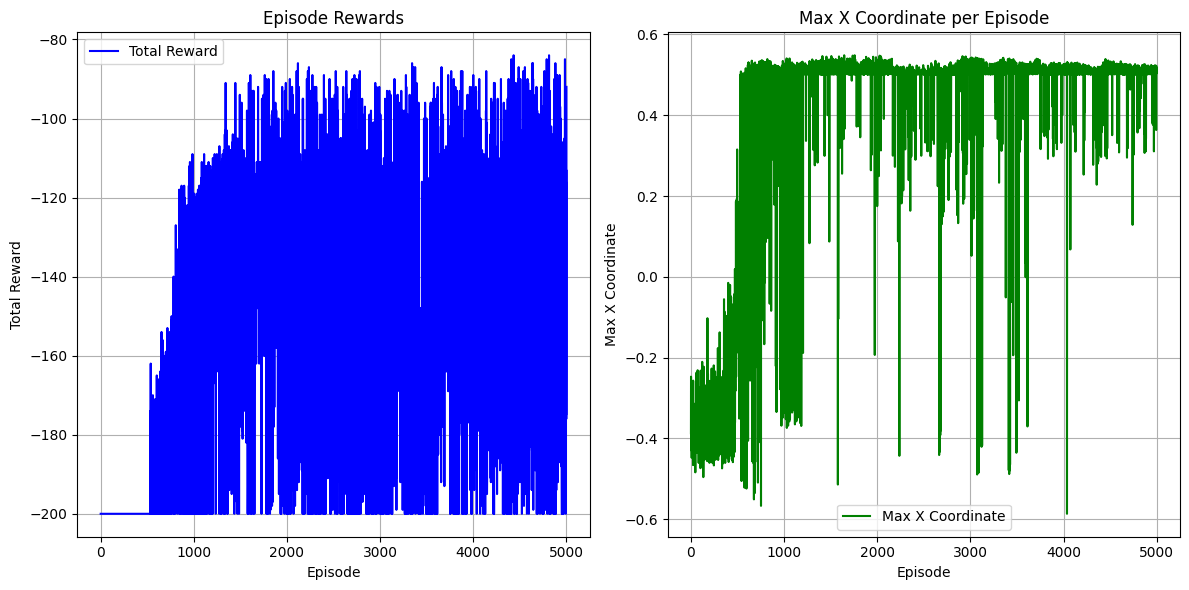

In [18]:
if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env = TransformObservation(env, lambda obs: th.tensor(obs, dtype=th.float32), observation_space=env.observation_space)

    train_config = TrainConfig(
        gamma=0.99,
        learning_rate=1e-3,
        num_episodes=5000,
        batch_size=64,
        sync_target_steps=10,
        memory_capacity=10000,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=1000
    )

    policy = Policy(PolicyConfig(
        n_observations=env.observation_space.shape[0],
        n_actions=env.action_space.n,
        device=th.device("cuda" if th.cuda.is_available() else "cpu"),
        epsilon_start=train_config.epsilon_start,
        epsilon_end=train_config.epsilon_end,
        epsilon_decay=train_config.epsilon_decay
    ))

    trainer = Trainer(env, train_config, policy)
    trainer.train()


<p class="task" id="7"></p>

7\. Загрузите состояния моделей из файлов, которые были получены в процессе обучения. Создайте окружение и сыграйте эпизод, используя стратегию, выведенную из обученной Q-функции.

- [ ] Проверено на семинаре

In [19]:
if __name__ == "__main__":
    # Создаём окружение
    env = gym.make("MountainCar-v0", render_mode="human")
    env = TransformObservation(env, lambda obs: th.tensor(obs, dtype=th.float32), observation_space=env.observation_space)

    # Загрузка моделей
    policy.load(policy_path, target_path)

    # Тестирование модели
    state, _ = env.reset()
    state = state.clone().detach().unsqueeze(0).to(policy.cfg.device)
    done = False
    total_reward = 0

    while not done:
        action = policy.get_best_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state.clone().detach().unsqueeze(0).to(policy.cfg.device)
        total_reward += reward

    env.close()
    print(f"Total reward in test episode: {total_reward}")


<ipython-input-14-7b4e68fbe25f>:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_network.load_state_dict(th.load(policy_path, map_location=self.cfg.device))
<i

Total reward in test episode: -120.0


## Обратная связь
- [ ] Хочу получить обратную связь по решению